In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My\ Drive/masters

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN, evaluate_fnn
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_results, save_metrics, compare_all_models, get_models_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths, by_ref
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn

from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from time import time
from torch.optim import lr_scheduler

In [2]:
data_sub_paths = get_data_sub_paths()
print(np.sort(data_sub_paths))

['T168H-X1275M-Y1320M_2001-01-04_2019-01-03_#1f1'
 'T1H-X2550M-Y2640M_2014-01-01_2019-01-01_#7ce'
 'T24H-X1275M-Y1320M_2012-01-01_2019-01-01_#939'
 'T24H-X1700M-Y1760M_2014-01-01_2019-01-01_#828'
 'T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97'
 'T24H-X425M-Y440M_2012-01-01_2019-01-01_#827'
 'T24H-X850M-Y880M_2012-01-01_2019-01-01_#826'
 'Totals_T168H_2001-01-04_2019-01-10_LAT41.641_42.024_LON-87.821_-87.525'
 'Totals_T1H_2014-01-01_2019-01-01_LAT41.641_42.024_LON-87.821_-87.525'
 'Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525']


In [4]:
data_sub_paths = by_ref("939")
data_sub_paths

['T24H-X1275M-Y1320M_2012-01-01_2019-01-01_#939']

In [5]:
from pprint import pprint
conf = BaseConf()

In [6]:
log.getLogger().setLevel("INFO")

In [7]:
# T24H-X850M-Y880M_2012-01-01_2019-01-01

data_sub_path = data_sub_paths[0]

# manually set
conf = BaseConf()
conf.seed = int(time()) # 3
conf.model_name = "KangFNN" 
# conf.model_name = "SimpleKangFNN"
conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2021-01-17T09:35:47 | root | INFO | =====================================BEGIN=====================================
2021-01-17T09:35:47 | root | INFO | Device: cpu


In [8]:
# SET THE HYPER PARAMETERS
conf.resume = False
conf.early_stopping = True
conf.patience = 10
conf.min_epochs = 1
conf.max_epochs = 100 # conf.min_epochs + conf.patience + 100
conf.dropout = 0 # 0.5 # should be between 0.5 and 0.8 for input dropout rates
conf.weight_decay = 0  # [0, 1e-8, 1e-6, 1e-4, 1e-2]
conf.checkpoint = "latest" #"latest" # ["best_val", "best_trn", "best_trn_val"]
conf.lr = 1e-3
conf.shaper_top_k = -1
conf.batch_size = 128
conf.use_classification = False
conf.train_set_first = True

MOCK = False

if MOCK:
    # MOCK THE DATA
    vector_size= [5,5,5]#[37,65,512]    
    class_split=0.5
    train_loader = MockLoader(vector_size, conf.batch_size, n_samples=1000, class_split=class_split)
    validation_loader = MockLoader(vector_size, conf.batch_size, n_samples=200, class_split=class_split)
    test_loader = MockLoader(vector_size, conf.batch_size, n_samples=300, class_split=class_split)
    loaders = MockLoaders(train_loader,validation_loader,test_loader)
else:
    # CRIME DATA - sub-sample classes to even out class label ratios
    conf.sub_sample_test_set = 0
    conf.sub_sample_train_set = 2 # 1 # 2 # 5 # 10
    conf.sub_sample_validation_set = 2 # 1 # 2 # 5 # 10

    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)

conf.freqstr = data_group.t_range.freqstr    

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
if conf.use_classification:
    output_size = 2
    loss_function = nn.CrossEntropyLoss()
    log.info("loss function: cross entropy loss")
else:
    output_size = 1
    loss_function = nn.MSELoss()
    log.info("loss function: mean square error loss")

# SETUP MODEL
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target, labels = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]

if conf.model_name == "SimpleKangFNN":
    model_arch = {
        "h_size0": 9,
        "h_size1": 3,
        "h_size2": 3,
    }
    model = SimpleKangFNN(spc_size=spc_size,
                          tmp_size=tmp_size,
                          env_size=env_size,
                          output_size=output_size,
                          dropout_p=conf.dropout,
                          model_arch=model_arch)
else:
#     model_arch = {
#         "scp_net_h0": 64,
#         "scp_net_h1": 32,
#         "tmp_net_h0": 64,
#         "tmp_net_h1": 32,
#         "env_net_h0": 64,
#         "env_net_h1": 32,
#         "final_net_h1": 64,
#     }
    
    model_arch = None # if none will use default architechture
    
    model = KangFeedForwardNetwork(spc_size=spc_size,
                                   tmp_size=tmp_size,
                                   env_size=env_size,
                                   output_size=output_size,
                                   dropout_p=conf.dropout,
                                   model_arch=model_arch)

    
pprint(conf)
model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()

# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay, amsgrad=False)
# optimiser = optim.SGD(params=parameters, lr=conf.lr)
scheduler = None
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimiser, T_max=10)#conf.max_epochs//5)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=10,
#                                            threshold=0.0001, threshold_mode='rel', cooldown=0,
#                                            min_lr=0, eps=1e-08, verbose=False)


##### RESUME LOGIC
if conf.resume:  # todo check if the files actually exist
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

        # new model hyper-parameters
        model.dropout.p = conf.dropout # note that drop out is not part of the saved state dict

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

2021-01-17T09:36:00 | root | INFO | Initialising Flat Data Group
2021-01-17T09:36:00 | root | INFO | loading crimes grids WITHOUT crime types
2021-01-17T09:36:00 | root | INFO | 	t_range: (2558,) 2012-01-01 00:00:00 -> 2019-01-01 00:00:00
2021-01-17T09:36:00 | root | INFO | 	target_len:	2191	(100.000%)
2021-01-17T09:36:00 | root | INFO | 	trn_val_size:	1831	(83.569%)
2021-01-17T09:36:00 | root | INFO | 	trn_size:	1374	(62.711%)
2021-01-17T09:36:00 | root | INFO | 	val_size:	457	(20.858%)
2021-01-17T09:36:00 | root | INFO | 	tst_size:	360 	(16.431%)
2021-01-17T09:36:01 | root | INFO | loss function: mean square error loss
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'latest',
 'data_path': './data/processed/T24H-X1275M-Y1320M_2012-01-01_2019-01-01_#939/',
 'device': device(type='cpu'),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'freqstr': '24H',
 'log_norm_scale': True,
 'lr': 0.001,
 'max_epochs': 100,
 'min_epochs': 1,
 'model_name': 'KangFNN',
 

2020-11-24T12:21:16 | root | INFO | 
 ====================== Training KangFNN ====================== 

2020-11-24T12:21:16 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'latest',
 'data_path': './data/processed/T1H-X2550M-Y2640M_2014-01-01_2017-01-01_#7ce/',
 'device': device(type='cpu'),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'freqstr': 'H',
 'log_norm_scale': True,
 'lr': 0.001,
 'max_epochs': 100,
 'min_epochs': 1,
 'model_name': 'KangFNN',
 'model_path': './data/processed/T1H-X2550M-Y2640M_2014-01-01_2017-01-01_#7ce/models/KangFNN/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 10,
 'resume': False,
 'scale_axis': 1,
 'seed': 1606213275,
 'seq_len': 1,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': True,
 'sub_sample_test_set': 0,
 'sub_sample_train_set': 2,
 'sub_

2020-11-24T12:37:56 | root | INFO | 	Loss (Val): 		0.01065517
2020-11-24T12:37:56 | root | INFO | 	Loss (Best Val): 	0.01059574
2020-11-24T12:37:56 | root | INFO | 	Loss (Trn Val Dif): 	0.00035472

2020-11-24T12:37:56 | root | INFO | Epoch: 0019/0100
2020-11-24T12:38:52 | root | INFO | 	Loss (Trn): 		0.01028288
2020-11-24T12:38:52 | root | INFO | 	Loss (Best Trn): 	0.01028288
2020-11-24T12:38:52 | root | INFO | 	Loss (Val): 		0.01072504
2020-11-24T12:38:52 | root | INFO | 	Loss (Best Val): 	0.01059574
2020-11-24T12:38:52 | root | INFO | 	Loss (Trn Val Dif): 	0.00044216

2020-11-24T12:38:52 | root | INFO | Epoch: 0020/0100
2020-11-24T12:39:50 | root | INFO | 	Loss (Trn): 		0.01025743
2020-11-24T12:39:50 | root | INFO | 	Loss (Best Trn): 	0.01025743
2020-11-24T12:39:50 | root | INFO | 	Loss (Val): 		0.01070455
2020-11-24T12:39:50 | root | INFO | 	Loss (Best Val): 	0.01059574
2020-11-24T12:39:50 | root | INFO | 	Loss (Trn Val Dif): 	0.00044712

2020-11-24T12:39:50 | root | INFO | Epoch: 0

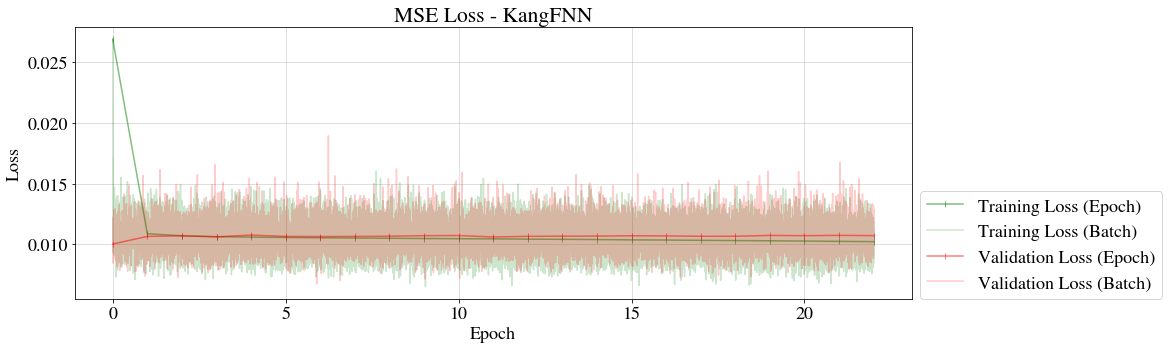

In [9]:
trn_epoch_losses, val_epoch_losses, stopped_early = train_model(
    model=model,
    optimiser=optimiser,
    loaders=loaders,
    train_epoch_fn=train_epoch_for_fnn,
    loss_fn=loss_function,
    conf=conf,
    scheduler=scheduler,
)    

print(f"stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

In [18]:
from utils.interactive import plot_interactive_epoch_losses
plot_interactive_epoch_losses(trn_epoch_losses, val_epoch_losses)

# Evaluation

In [33]:
# Load latest or best validation model
# conf.checkpoint = "latest"
conf.checkpoint = "best_val"
# conf.checkpoint = "best_trn"

conf.model_name = f"{model.name}"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                map_location=conf.device.type)
model.load_state_dict(model_state_dict)


2020-11-24T13:10:19 | root | INFO | Loading model from checkpoint (best_val) for evaluation


<All keys matched successfully>

In [34]:
conf.sub_sample_test_set = 0
conf.sub_sample_train_set = 0
conf.sub_sample_validation_set = 0

loaders = FlatDataLoaders(data_group=data_group, conf=conf)

In [35]:
# todo set the train_loader to eval so that it does not subsample
trn_y_count, trn_y_class, trn_y_score, trn_t_range = evaluate_fnn(model=model,
                                                        batch_loader=loaders.train_loader,
                                                        conf=conf)

tst_y_count, tst_y_class, tst_y_score, tst_t_range = evaluate_fnn(model=model,
                                                        batch_loader=loaders.test_loader,
                                                        conf=conf)

thresh = best_threshold(y_class=trn_y_class,
                        y_score=trn_y_score)

tst_y_pred = get_y_pred(thresh=thresh,
                        y_score=tst_y_score)    

tst_y_count = loaders.data_group.to_counts(tst_y_count)     
        
save_metrics(y_count=tst_y_count,
             y_pred=tst_y_pred,
             y_score=tst_y_score,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)   

# save_results(y_true=tst_y_true,
#              y_pred=tst_y_pred,
#              probas_pred=tst_probas_pred,
#              t_range=tst_t_range,
#              shaper=data_group.shaper,                
#              conf=conf)

2020-11-24T13:11:39 | root | INFO | f1_score: 0.4876716709034805 at index 378244, new threshold 0.12639620900154114


/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning:

invalid value encountered in double_scalars



2020-11-24T13:12:21 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:3.912
                Model Name: KangFNN
                    NDCG:               0.67226                
                    ROC AUC:            0.76723                
                    Average Precision:  0.45069
                    Precision:          0.38790
                    Recall:             0.64433
                    Accuracy:           0.72058
                    MCC:                0.32718
                    PAI:                2.03829
                    MAE:                0.30046
                    RMSE:               0.58148      
            


```
2020-11-24T08:39:43 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:3.912
                Model Name: SimpleKangFNN
                    NDCG:               0.67464                
                    ROC AUC:            0.76796                
                    Average Precision:  0.45334
                    Precision:          0.38324
                    Recall:             0.66191
                    Accuracy:           0.71428
                    MCC:                0.32854
                    PAI:                2.00751
                    MAE:                0.29715
                    RMSE:               0.58282   

```

,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.675668,0.452320,0.765756,0.450654,0.383750,0.654098,0.483713,0.715717,0.326155,2.010857,0.604195,0.273351
SimpleKangFNN,0.673367,0.450412,0.767105,0.449810,0.386531,0.649843,0.484738,0.718723,0.327734,2.029459,0.582544,0.300915
Global Average,0.673363,0.450470,0.743988,0.399999,0.353731,0.659012,0.460359,0.685439,0.291462,1.844392,0.607679,0.276165
Ind-Hawkes Model,0.673008,0.449022,0.757852,0.442457,0.373592,0.649360,0.474305,0.706934,0.312433,1.958410,0.593107,0.281561
ST-RESNET,0.672291,0.448711,0.767203,0.452458,0.390908,0.638277,0.484864,0.723869,0.328257,2.056815,0.603824,0.273208
KangFNN,0.672255,0.450092,0.767226,0.450694,0.387899,0.644335,0.484264,0.720577,0.327184,2.038294,0.581482,0.300455
RFNN,0.605060,0.339171,0.548463,0.315595,0.329855,0.368350,0.348041,0.719034,0.170086,1.692534,0.607099,0.319770
Previous Time Step,0.576200,0.270951,0.586590,0.261741,0.336673,0.336642,0.336658,0.729902,0.167085,1.790478,0.608262,0.272325


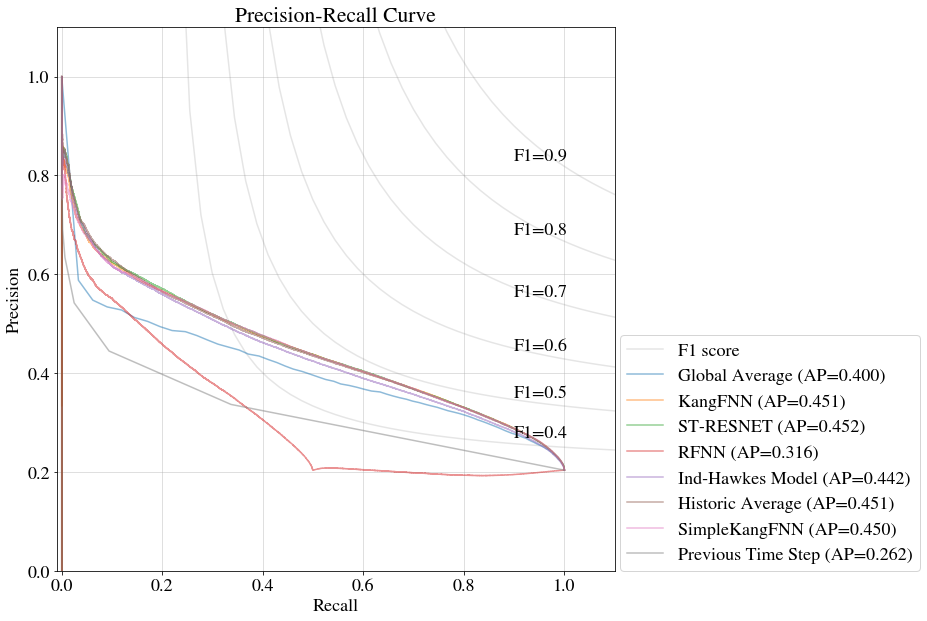

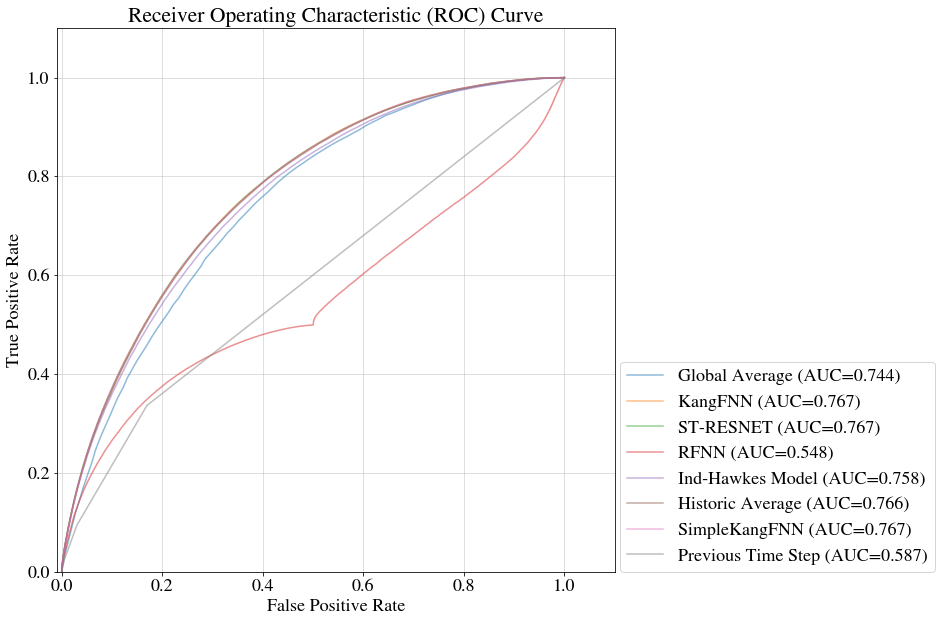

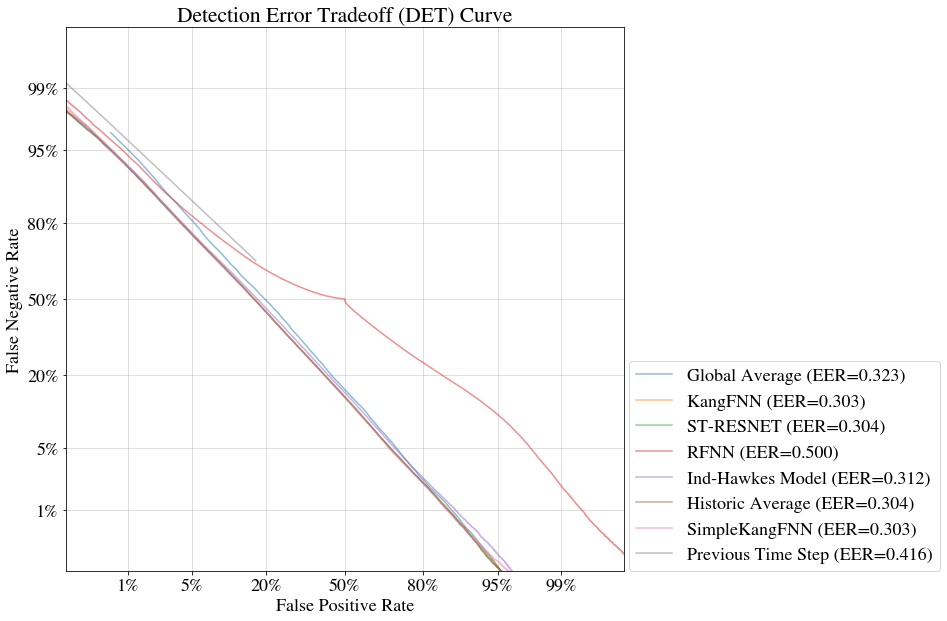

,NDCG,MAP,ROC AUC,AP,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,,,
Historic Average,0.675668,0.452320,0.765756,0.450654,0.383750,0.654098,0.483713,0.715717,0.326155,2.010857,0.604195,0.273351
SimpleKangFNN,0.673367,0.450412,0.767105,0.449810,0.386531,0.649843,0.484738,0.718723,0.327734,2.029459,0.582544,0.300915
Global Average,0.673363,0.450470,0.743988,0.399999,0.353731,0.659012,0.460359,0.685439,0.291462,1.844392,0.607679,0.276165
Ind-Hawkes Model,0.673008,0.449022,0.757852,0.442457,0.373592,0.649360,0.474305,0.706934,0.312433,1.958410,0.593107,0.281561
ST-RESNET,0.672291,0.448711,0.767203,0.452458,0.390908,0.638277,0.484864,0.723869,0.328257,2.056815,0.603824,0.273208
KangFNN,0.672255,0.450092,0.767226,0.450694,0.387899,0.644335,0.484264,0.720577,0.327184,2.038294,0.581482,0.300455
RFNN,0.605060,0.339171,0.548463,0.315595,0.329855,0.368350,0.348041,0.719034,0.170086,1.692534,0.607099,0.319770
Previous Time Step,0.576200,0.270951,0.586590,0.261741,0.336673,0.336642,0.336658,0.729902,0.167085,1.790478,0.608262,0.272325


In [39]:
compare_all_models(data_path=conf.data_path)

In [27]:
# from utils.interactive import plot_interactive_roc, plot_interactive_pr, plot_interactive_det
# plot_interactive_pr(conf.data_path,beta=1).show()
# plot_interactive_roc(conf.data_path).show()
# plot_interactive_det(conf.data_path).show()

### View Training Predictions

In [40]:
trn_y_count, trn_y_class, trn_y_score, trn_t_range = evaluate_fnn(model=model,
                                                                  batch_loader=loaders.train_loader,
                                                                  conf=conf)

thresh = best_threshold(y_class=trn_y_class,
                        y_score=trn_y_score)

trn_y_pred = get_y_pred(thresh=thresh,
                        y_score=trn_y_score)

trn_y_count = data_group.shaper.unsqueeze(trn_y_count)
trn_y_class = data_group.shaper.unsqueeze(trn_y_class)
trn_y_score = data_group.shaper.unsqueeze(trn_y_score)
trn_y_pred = data_group.shaper.unsqueeze(trn_y_pred)

from utils.interactive import InteractiveHeatmapsWithLines


kwargs = {
    "True Counts":trn_y_count[:,0], 
    "True Hotspots":trn_y_class[:,0],
    "Predicted Score":trn_y_score[:,0],
    "Predicted Hotspots":trn_y_pred[:,0],
}

for k in kwargs.keys():
    kwargs[k] = np.flip(kwargs[k],1)


InteractiveHeatmapsWithLines(
    date_range=trn_t_range, 
    col_wrap=2,
    thresh=thresh,
    **kwargs,
).app

2020-11-24T15:55:38 | root | INFO | f1_score: 0.4876716709034805 at index 378237, new threshold 0.12639620900154114


### View Testing Predictions

In [41]:
from utils.interactive import InteractiveHeatmapsWithLines

tst_y_count, tst_y_class, tst_y_score, tst_t_range = evaluate_fnn(model=model,
                                                                  batch_loader=loaders.test_loader,
                                                                  conf=conf)

# thresh = best_threshold(y_class=trn_y_class,
#                         y_score=trn_y_score)

thresh = best_threshold(y_class=tst_y_class,
                        y_score=tst_y_score)

tst_y_pred = get_y_pred(thresh=thresh,
                        y_score=tst_y_score) 

tst_y_count = data_group.shaper.unsqueeze(tst_y_count)
tst_y_class = data_group.shaper.unsqueeze(tst_y_class)
tst_y_score = data_group.shaper.unsqueeze(tst_y_score)
tst_y_pred = data_group.shaper.unsqueeze(tst_y_pred)


kwargs = {
    "True Counts":tst_y_count[:,0], 
    "True Hotspots":tst_y_class[:,0],
    "Predicted Score":tst_y_score[:,0],
    "Predicted Hotspots":tst_y_pred[:,0],
}

for k in kwargs.keys():
    kwargs[k] = np.flip(kwargs[k],1)

InteractiveHeatmapsWithLines(
    date_range=tst_t_range, 
    col_wrap=2,
    **kwargs,
).app

2020-11-24T15:56:53 | root | INFO | f1_score: 0.48459278704919057 at index 479715, new threshold 0.12432803213596344
